# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari Kaggle (https://www.kaggle.com/datasets/dhairyajeetsingh/ecommerce-customer-behavior-dataset)

2. **Gambaran Umum Dataset**

Dataset ini merepresentasikan data keterlibatan pelanggan (customer engagement) dan perilaku churn pada sebuah platform e-commerce dan layanan berbasis langganan berskala global.  
Data mencakup informasi demografis, aktivitas pengguna di platform, perilaku transaksi, serta indikator nilai pelanggan yang dikumpulkan sepanjang siklus hidup pelanggan, mulai dari pendaftaran hingga status terkini.

Tujuan utama penggunaan dataset ini adalah untuk melakukan **prediksi churn pelanggan**, yaitu mengidentifikasi pelanggan yang berpotensi berhenti menggunakan layanan.  
Dengan demikian, dataset ini sesuai untuk pengembangan dan evaluasi pipeline machine learning yang mensimulasikan kasus nyata dalam strategi retensi pelanggan.

3. **Karakteristik Dataset**

- **Jumlah data:** 50.000 pelanggan  
- **Jumlah fitur:** 25 kolom  
- **Variabel target:** `Churned`  
  - `0` → Pelanggan aktif  
  - `1` → Pelanggan churn  
- **Tipe data:** Campuran (numerik, kategorikal, dan biner)  
- **Cakupan geografis:** Beberapa negara (Amerika Serikat, Inggris, Jerman, Kanada, India, Jepang, Prancis, Australia)

4. **Kelompok Fitur**

Dataset ini terdiri dari beberapa kelompok fitur utama yang merepresentasikan berbagai aspek perilaku pelanggan:

- **Demografi Pelanggan**  
   Mencakup atribut dasar pelanggan seperti usia, jenis kelamin, negara, kota, dan lama berlangganan.

- **Keterlibatan Pengguna di Platform**  
   Menggambarkan tingkat interaksi pelanggan dengan platform, termasuk frekuensi login, durasi sesi, aktivitas halaman, dan keterlibatan melalui email atau aplikasi mobile.

- **Perilaku Pembelian**  
   Mewakili pola transaksi pelanggan, seperti jumlah pembelian, nilai pesanan rata-rata, penggunaan diskon, dan jarak waktu sejak pembelian terakhir.

- **Layanan Pelanggan dan Nilai Pelanggan**  
   Berisi informasi terkait interaksi dengan layanan pelanggan serta indikator nilai jangka panjang pelanggan.

Pengelompokan fitur ini memberikan pandangan menyeluruh terhadap perilaku pelanggan yang relevan untuk analisis churn.

5. **Variabel Target**

Variabel target pada dataset ini adalah `Churned`, yaitu indikator biner yang menunjukkan status pelanggan:

- Nilai `1` menunjukkan pelanggan telah berhenti menggunakan layanan (churn)
- Nilai `0` menunjukkan pelanggan masih aktif menggunakan layanan

Dengan definisi tersebut, permasalahan churn pada dataset ini diformulasikan sebagai **masalah klasifikasi biner**.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


ROOT = Path("/content")
RAW_PATH = ROOT / "ecommerce_customer_churn_dataset.csv"

OUTDIR = Path("ecommerce_customer_behavior_preprocessing")
EDA_DIR = OUTDIR / "eda"
SPLITS_DIR = OUTDIR / "splits"
ART_DIR = OUTDIR / "artifacts"
OUT_PREPROC_DIR = Path("namadataset_preprocessing")

for p in [EDA_DIR, SPLITS_DIR, ART_DIR, OUT_PREPROC_DIR]:
    p.mkdir(parents=True, exist_ok=True)

SEED = 42
TEST_SIZE = 0.2

# **3. Memuat Dataset**

In [2]:
df = pd.read_csv(RAW_PATH)
df.head()

,Age,Gender,Country,City,Membership_Years,Login_Frequency,Session_Duration_Avg,Pages_Per_Session,Cart_Abandonment_Rate,Wishlist_Items,...,Email_Open_Rate,Customer_Service_Calls,Product_Reviews_Written,Social_Media_Engagement_Score,Mobile_App_Usage,Payment_Method_Diversity,Lifetime_Value,Credit_Balance,Churned,Signup_Quarter
0,43.0,Male,France,Marseille,2.9,14.0,27.4,6.0,50.6,3.0,...,17.9,9.0,4.0,16.3,20.8,1.0,953.33,2278.0,0.0,Q1
1,36.0,Male,UK,Manchester,1.6,15.0,42.7,10.3,37.7,1.0,...,42.8,7.0,3.0,NaN,23.3,3.0,1067.47,3028.0,0.0,Q4
2,45.0,Female,Canada,Vancouver,2.9,10.0,24.8,1.6,70.9,1.0,...,0.0,4.0,1.0,NaN,8.8,NaN,1289.75,2317.0,0.0,Q4
3,56.0,Female,USA,New York,2.6,10.0,38.4,14.8,41.7,9.0,...,41.4,2.0,5.0,85.9,31.0,3.0,2340.92,2674.0,0.0,Q1
4,35.0,Male,India,Delhi,3.1,29.0,51.4,NaN,19.1,9.0,...,37.9,1.0,11.0,83.0,50.4,4.0,3041.29,5354.0,0.0,Q4


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [3]:
churn_counts = df["Churned"].value_counts()
churn_pct = df["Churned"].value_counts(normalize=True) * 100

churn_summary = pd.DataFrame({
    "count": churn_counts,
    "percentage (%)": churn_pct.round(2)
})

churn_summary

,count,percentage (%)
Churned,,
0.0,24432,71.2
1.0,9882,28.8


In [4]:
print("Shape:", df.shape)
display(df.sample(5, random_state=SEED))

display(df.dtypes.value_counts())
display(df.isna().mean().sort_values(ascending=False).head(20))

dup = df.duplicated().sum()
print("Duplicates:", dup)

Shape: (34315, 25)


,Age,Gender,Country,City,Membership_Years,Login_Frequency,Session_Duration_Avg,Pages_Per_Session,Cart_Abandonment_Rate,Wishlist_Items,...,Email_Open_Rate,Customer_Service_Calls,Product_Reviews_Written,Social_Media_Engagement_Score,Mobile_App_Usage,Payment_Method_Diversity,Lifetime_Value,Credit_Balance,Churned,Signup_Quarter
3028,31.0,Female,Japan,Osaka,5.5,0.0,17.7,1.7,68.5,0.0,...,NaN,8.0,2.0,13.7,14.2,1.0,381.76,1403.0,0.0,Q2
32628,47.0,Male,USA,New York,2.8,11.0,16.8,6.9,58.2,6.0,...,16.3,12.0,2.0,16.6,16.4,1.0,1170.46,0.0,1.0,Q2
3115,41.0,Female,India,Bangalore,1.8,18.0,32.6,11.2,55.9,4.0,...,31.4,5.0,3.0,20.7,24.4,3.0,557.32,3480.0,0.0,Q3
11137,23.0,Male,UK,London,2.3,14.0,22.3,7.3,77.8,1.0,...,18.2,11.0,2.0,25.2,27.0,2.0,1372.66,1670.0,0.0,Q1
21742,57.0,Male,USA,Phoenix,1.5,17.0,48.3,11.5,37.3,3.0,...,21.8,2.0,7.0,48.3,NaN,1.0,2332.39,NaN,0.0,Q3


,count
float64,21
object,4


,0
Social_Media_Engagement_Score,0.119306
Credit_Balance,0.109194
Mobile_App_Usage,0.101209
Returns_Rate,0.090369
Wishlist_Items,0.081043
Discount_Usage_Rate,0.070232
Product_Reviews_Written,0.069357
Session_Duration_Avg,0.069357
Pages_Per_Session,0.061460
Days_Since_Last_Purchase,0.060440


Duplicates: 0


In [5]:
overview = {
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "columns": list(df.columns),
    "dtypes": {c: str(df[c].dtype) for c in df.columns},
    "missing_ratio": {c: float(df[c].isna().mean()) for c in df.columns},
    "n_duplicates": int(df.duplicated().sum()),
}
(EDA_DIR / "dataset_overview.json").write_text(json.dumps(overview, indent=2), encoding="utf-8")

2608

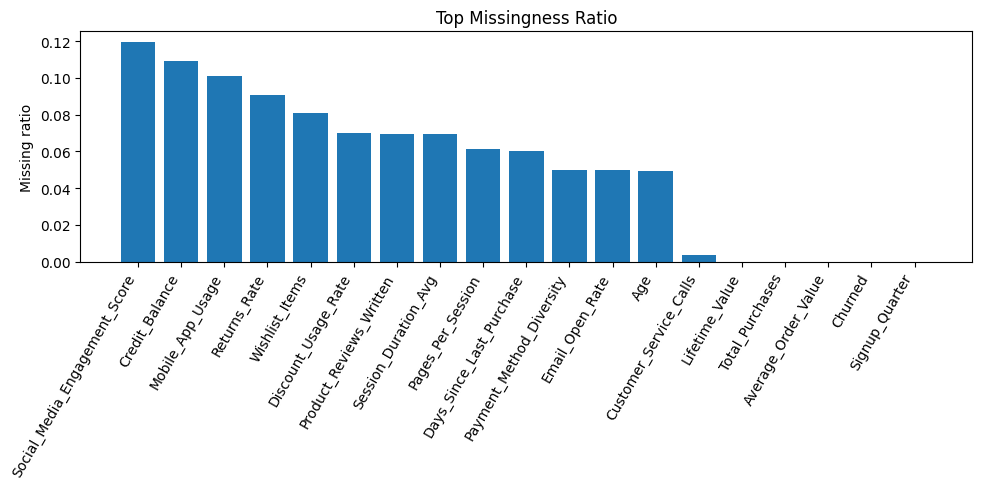

In [6]:
miss = df.isna().mean().sort_values(ascending=False)
miss = miss[miss > 0].head(25)

plt.figure(figsize=(10,5))
if len(miss)==0:
    plt.text(0.5,0.5,"No missing values detected", ha="center", va="center")
    plt.axis("off")
else:
    plt.bar(miss.index.astype(str), miss.values)
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Missing ratio")
    plt.title("Top Missingness Ratio")
    plt.tight_layout()
plt.savefig(EDA_DIR / "missingness.png", dpi=200)
plt.show()

,count,mean,std,min,25%,50%,75%,max
Age,32616.0,37.768764,11.725691,5.00,29.0000,37.000,46.000,200.000000
Membership_Years,34315.0,2.990565,2.054342,0.10,1.5000,2.500,4.000,10.000000
Login_Frequency,34315.0,11.612036,7.785868,0.00,6.0000,11.000,17.000,46.000000
Session_Duration_Avg,31935.0,27.606883,10.856659,1.00,19.6000,26.700,34.700,75.600000
Pages_Per_Session,32206.0,8.729706,3.782190,1.00,6.0000,8.400,11.200,24.100000
Cart_Abandonment_Rate,34315.0,57.111331,16.248818,0.00,46.6000,58.100,68.600,142.851486
Wishlist_Items,31534.0,4.290480,3.180852,0.00,2.0000,4.000,6.000,28.000000
Total_Purchases,34314.0,13.103491,7.024037,-11.70,8.0000,12.000,17.000,128.700000
Average_Order_Value,34314.0,122.960986,180.425106,26.38,86.7800,112.590,144.290,9666.379178
Days_Since_Last_Purchase,32241.0,29.726590,29.669115,0.00,9.0000,21.000,41.000,283.000000


,count,unique,top,freq
Gender,34315,3,Female,17247
Country,34315,8,USA,11891
City,34315,40,Houston,2444
Signup_Quarter,34314,4,Q2,8681


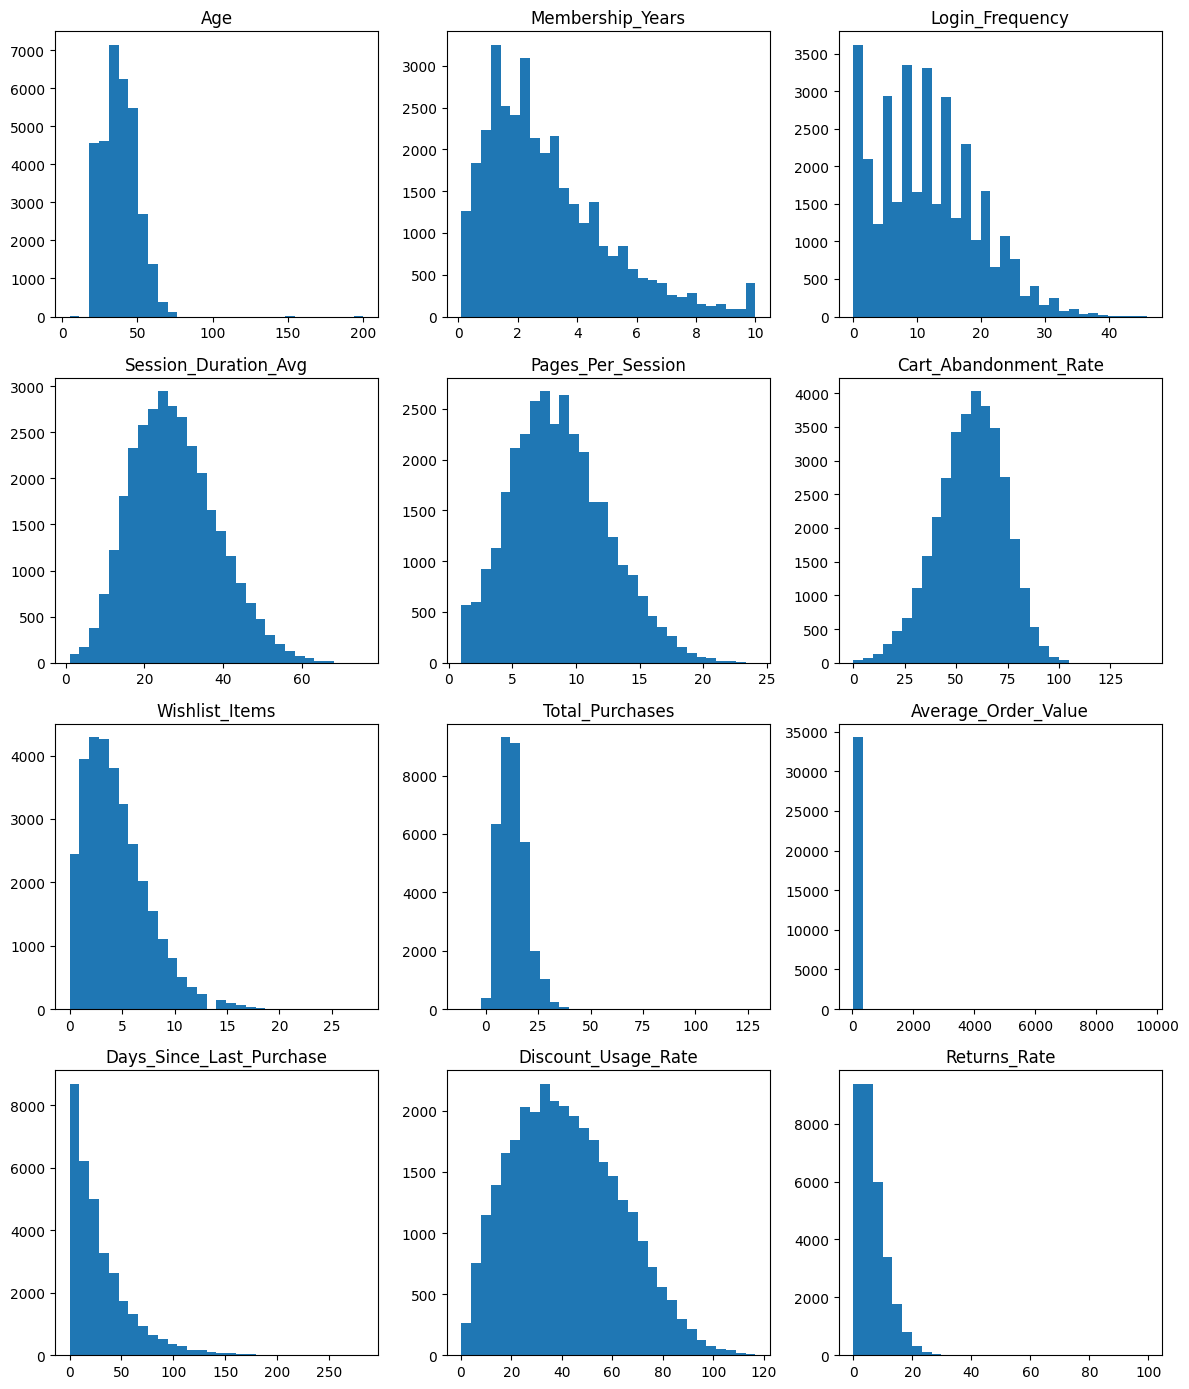

In [7]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

display(df[num_cols].describe().T if num_cols else "No numeric columns")
display(df[cat_cols].describe().T if cat_cols else "No categorical columns")

# distribusi numeric (maks 12)
use_num = num_cols[:12]
n = len(use_num)

if n > 0:
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(12, 3.5*nrows))
    for i, c in enumerate(use_num, 1):
        plt.subplot(nrows, ncols, i)
        plt.hist(df[c].dropna(), bins=30)
        plt.title(str(c))
    plt.tight_layout()
    plt.savefig(EDA_DIR / "numeric_distributions.png", dpi=200)
    plt.show()
else:
    print("No numeric columns detected.")

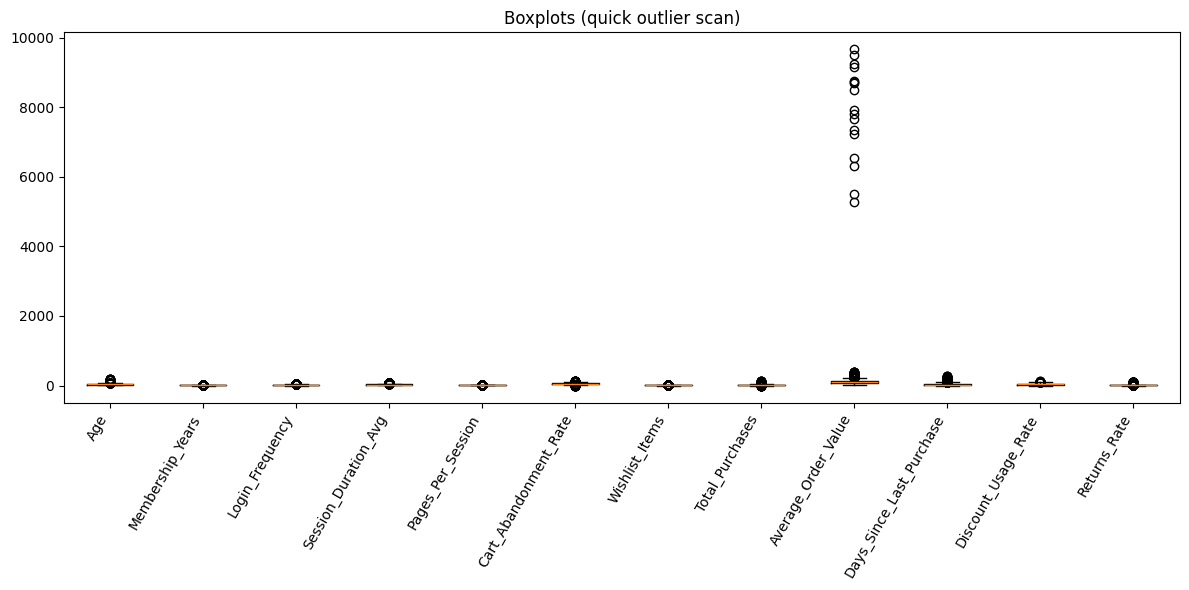

In [8]:
use_num = num_cols[:12]
if len(use_num) > 0:
    plt.figure(figsize=(12,6))
    plt.boxplot([df[c].dropna().to_numpy() for c in use_num],
                tick_labels=[str(c) for c in use_num])
    plt.xticks(rotation=60, ha="right")
    plt.title("Boxplots (quick outlier scan)")
    plt.tight_layout()
    plt.savefig(EDA_DIR / "outlier_boxplots.png", dpi=200)
    plt.show()
else:
    print("No numeric columns detected.")

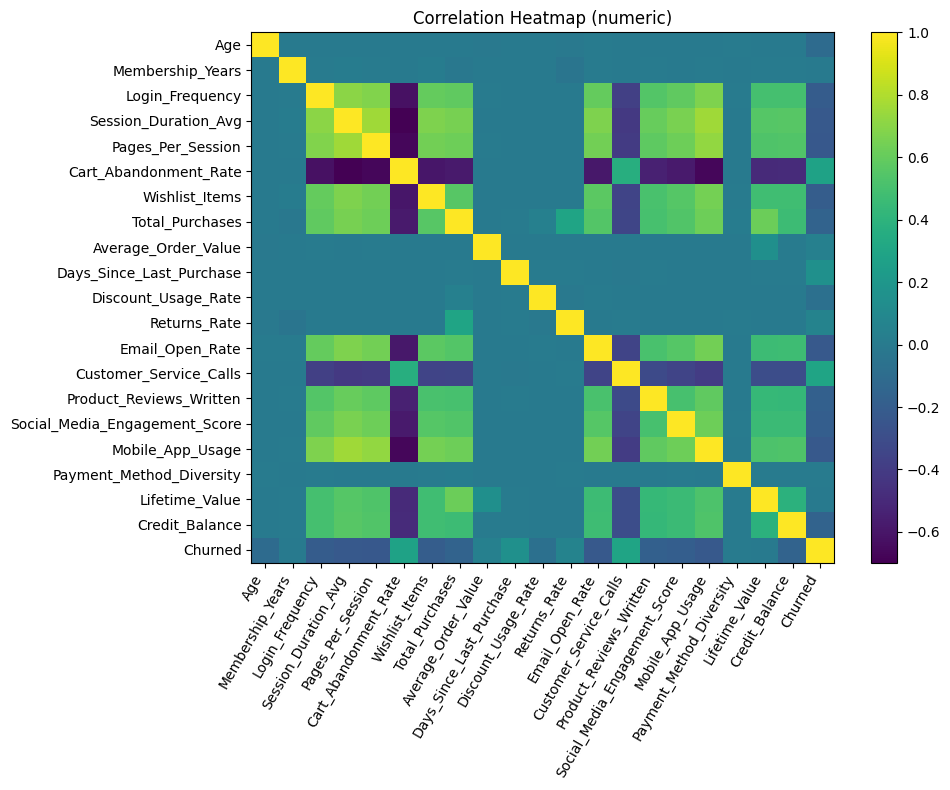

In [9]:
if len(num_cols) >= 2:
    corr = df[num_cols[:25]].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    plt.imshow(corr.to_numpy(), aspect="auto")
    plt.colorbar()
    plt.xticks(range(corr.shape[1]), corr.columns.astype(str), rotation=60, ha="right")
    plt.yticks(range(corr.shape[0]), corr.index.astype(str))
    plt.title("Correlation Heatmap (numeric)")
    plt.tight_layout()
    plt.savefig(EDA_DIR / "corr_heatmap.png", dpi=200)
    plt.show()
else:
    print("Not enough numeric columns for correlation.")

In [10]:
for c in cat_cols[:10]:
    vc = df[c].astype(str).str.strip().value_counts(dropna=False).head(10)
    print(f"\n== {c} (top 10) ==")
    display(vc)


== Gender (top 10) ==


,count
Gender,
Female,17247
Male,16423
Other,645



== Country (top 10) ==


,count
Country,
USA,11891
UK,5176
Canada,4170
Germany,3409
Australia,2791
France,2717
India,2391
Japan,1770



== City (top 10) ==


,count
City,
Houston,2444
Phoenix,2400
Chicago,2376
New York,2359
Los Angeles,2312
Manchester,1066
Leeds,1060
Birmingham,1044
London,1014



== Signup_Quarter (top 10) ==


,count
Signup_Quarter,
Q2,8681
Q3,8569
Q4,8565
Q1,8499
nan,1


In [11]:
def detect_target_column(df: pd.DataFrame):
    lowered = {c: c.lower().strip() for c in df.columns}

    priority_keys = ["churn", "churned", "target", "label", "exited", "attrition"]

    for c, lc in lowered.items():
        if any(k in lc for k in priority_keys):
            return c

    for c, lc in lowered.items():
        if lc == "y":
            return c

    for c in df.columns:
        s = df[c].dropna()
        if s.empty:
            continue
        uniq = pd.unique(s)
        if len(uniq) == 2:
            normalized = set(str(u).strip().lower() for u in uniq)
            if normalized.issubset({"0","1","yes","no","true","false","y","n"}):
                return c

    return None

In [17]:
target_col = "Churned"

if target_col not in df.columns:
    raise ValueError(f"Kolom target '{target_col}' tidak ada.")

df = df.dropna(subset=[target_col]).copy()

# cek distribusi target setelah dibersihkan
display(df[target_col].value_counts(dropna=False))

X = df.drop(columns=[target_col]).copy()
y = df[target_col].to_numpy()

idx = np.arange(len(df))
stratify = y

train_idx, test_idx = train_test_split(
    idx, test_size=TEST_SIZE, random_state=SEED, stratify=stratify
)

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y[train_idx], y[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)

,count
Churned,
0.0,24432
1.0,9882


Train: (27451, 24) Test: (6863, 24)


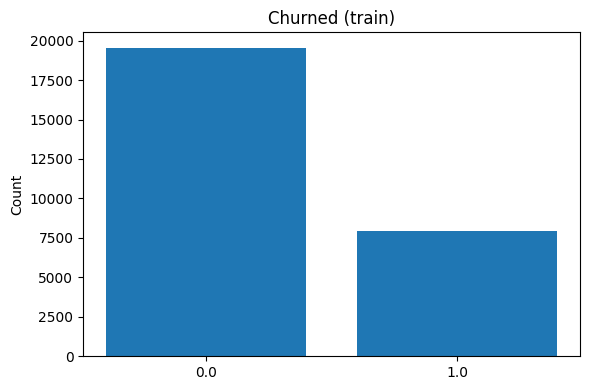

In [18]:
plt.figure(figsize=(6,4))
vals, counts = np.unique(y_train, return_counts=True)
plt.bar([str(v) for v in vals], counts)
plt.title(f"{target_col} (train)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(EDA_DIR / "target_distribution.png", dpi=200)
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [19]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True)),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

print("Processed shapes:", X_train_p.shape, X_test_p.shape)

Processed shapes: (27451, 75) (6863, 75)


In [20]:
dump(preprocessor, ART_DIR / "preprocessor.joblib")

# feature names (jika tersedia)
try:
    feat_names = [str(n) for n in preprocessor.get_feature_names_out()]
except Exception:
    feat_names = []
(ART_DIR / "feature_names.json").write_text(json.dumps(feat_names, indent=2), encoding="utf-8")

def save_matrix(X, base_path: Path):
    if sparse.issparse(X):
        out = base_path.with_suffix(".npz")
        sparse.save_npz(out, X.tocsr())
        return out
    out = base_path.with_suffix(".npy")
    np.save(out, X)
    return out

save_matrix(X_train_p, ART_DIR / "X_train")
save_matrix(X_test_p, ART_DIR / "X_test")
np.save(ART_DIR / "y_train.npy", y_train)
np.save(ART_DIR / "y_test.npy", y_test)

print("Saved to:", OUTDIR.resolve())

Saved to: /content/ecommerce_customer_behavior_preprocessing


In [21]:
if not feat_names:
    # fallback kalau get_feature_names_out gagal
    feat_names = [f"f{i}" for i in range(X_train_p.shape[1])]

# Guard agar tidak crash saat one-hot menghasilkan fitur sangat banyak
n_features = X_train_p.shape[1]
if n_features > 5000:
    raise MemoryError(
        f"Jumlah fitur setelah preprocessing terlalu besar ({n_features}). "
        "CSV dense berisiko crash. Solusi: drop kolom kategori high-cardinality (mis. City) atau simpan processed sebagai parquet/npz."
    )

# convert sparse->dense untuk CSV
X_train_dense = X_train_p.toarray() if sparse.issparse(X_train_p) else X_train_p
X_test_dense  = X_test_p.toarray()  if sparse.issparse(X_test_p)  else X_test_p

train_df = pd.DataFrame(X_train_dense, columns=feat_names)
test_df  = pd.DataFrame(X_test_dense, columns=feat_names)

# Tambah target
train_df[target_col] = y_train
test_df[target_col] = y_test

# Simpan dataset hasil preprocessing (sesuai struktur folder)
train_df.to_csv(OUTDIR / "processed_train.csv", index=False)
test_df.to_csv(OUTDIR / "processed_test.csv", index=False)

print("Saved processed datasets:")
print(" -", (OUTDIR / "processed_train.csv").resolve())
print(" -", (OUTDIR / "processed_test.csv").resolve())

Saved processed datasets:
 - /content/ecommerce_customer_behavior_preprocessing/processed_train.csv
 - /content/ecommerce_customer_behavior_preprocessing/processed_test.csv
